In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import get_data, get_preds, get_table
np.random.seed(2024)
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=1000, size_test=10000)
train["propleft"] = 1 - train["prop"]
test["propleft"] = 1 - test["prop"]
train["propxcurr"] = train["prop"] * train["curr_pace"]
test["propxcurr"] = test["prop"] * test["curr_pace"]

train['male'] = train['gender'].apply(lambda x: 1 if x == 'M' else 0)
test['male'] = test['gender'].apply(lambda x: 1 if x == 'M' else 0)
train.to_csv("train.csv")
test.to_csv("test.csv")
# test = pd.read_csv("test.csv")

In [16]:
model_info = {
    # "rstan1a" : ("stan_results/rs_result1a.csv", ["total_pace"], ["beta[1]"], False),
    # "rstan1b" : ("stan_results/rs_result1b.csv", ["total_pace", "curr_pace"], ["beta[1]", "beta[2]"], False),
    # "rstan1c" : ("stan_results/rs_result1c.csv", ["total_pace", "prop"],  ["beta[1]", "beta[2]"], False),
    # "rstan1d" : ("stan_results/rs_result1d.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], False),

    # "rstan2a" : ("stan_results/rs_result2a.csv", ["total_pace"], ["beta[1]"], True),
    # "rstan2b" : ("stan_results/rs_result2b.csv", ["total_pace", "curr_pace"],  ["beta[1]", "beta[2]"], True),
    "rstan2c" : ("stan_results/rs_result2c.csv", ["total_pace", "prop"], ["beta[1]", "beta[2]"], True),
    "rstan2d" : ("stan_results/rs_result2d.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], True),

    "rstan3a" : ("stan_results/rs_result3a.csv", ["total_pace", "curr_pace", "prop", "propxcurr"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]"], True),
    "rstan3b" : ("stan_results/rs_result3b.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], True),

    # "rstan3c" : ("stan_results/rs_result_1.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], True),
}

models = {k: pd.read_csv(v[0]) for k, v in model_info.items()}

In [17]:
model_preds = {}

for k, v in model_info.items():
    print(k, v)
    preds = get_preds(test, pd.read_csv(v[0]), feats_lis=v[1], beta_lis=v[2], propleft=v[3])
    model_preds[k] = preds

rstan2c ('stan_results/rs_result2c.csv', ['total_pace', 'prop'], ['beta[1]', 'beta[2]'], True)
rstan2d ('stan_results/rs_result2d.csv', ['total_pace', 'curr_pace', 'prop'], ['beta[1]', 'beta[2]', 'beta[3]'], True)
rstan3a ('stan_results/rs_result3a.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]'], True)
rstan3b ('stan_results/rs_result3b.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr', 'male'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], True)


In [4]:
s_data =pd.DataFrame([[4, 0.2, .5], [3, 0.5, .5]], columns=["total_pace", "prop", "propleft"])
get_preds(s_data, models['rstan2c'], feats_lis = ["total_pace", "prop"], beta_lis = ["beta[1]", "beta[2]"], full=True)

array([[3.73981187, 3.80999838, 3.44637135, ..., 3.8644297 , 3.36712784,
        3.91457544],
       [2.66721395, 3.19403738, 2.58693037, ..., 2.67723444, 2.93045089,
        2.50204861]])

In [19]:
test2 = test.copy()
for k, v in model_preds.items():
    test2[k] = get_table(v)["stan"]
test2["extrap"] = get_table(model_preds["rstan3a"])["extrap"]
test2

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,propxcurr,male,rstan2c,rstan2d,rstan3a,rstan3b,extrap
0,286777,5K,5.827506,5.827506,5.585782,34,M,2023,0.118497,0.881503,0.690545,1,0.354997,0.343994,-2.658484,-2.954081,-5.222300
1,286778,5K,5.827506,5.827506,5.578398,26,M,2023,0.118497,0.881503,0.690545,1,0.132272,0.029768,-2.799861,-2.959272,-5.388967
7,286784,5K,5.773672,5.773672,5.419342,33,M,2023,0.118497,0.881503,0.684165,1,-2.400589,-2.305360,-5.264815,-5.480048,-7.963767
8,286785,5K,5.827506,5.827506,5.406843,26,M,2023,0.118497,0.881503,0.690545,1,-3.956657,-3.807877,-6.961421,-6.999725,-9.388967
9,286786,5K,5.780347,5.780347,5.397851,29,M,2023,0.118497,0.881503,0.684956,1,-2.921649,-3.147240,-6.116866,-6.197461,-8.621083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208204,312785,40K,1.779359,1.892595,1.882529,72,M,2023,0.947980,0.052020,1.686796,1,-0.512465,-2.687142,-3.233904,-3.294845,-1.986948
208209,312790,40K,1.749475,1.853482,1.855622,39,F,2023,0.947980,0.052020,1.658467,0,1.978675,-0.449258,-1.004087,-1.888119,0.437623
208213,312794,40K,1.663894,1.816201,1.810478,73,M,2023,0.947980,0.052020,1.577337,1,0.346260,-1.309582,-2.055306,-2.127020,-1.223883
208221,312802,40K,1.619171,1.696209,1.688205,59,F,2023,0.947980,0.052020,1.534941,0,-0.273149,-3.867382,-4.694928,-5.515723,-1.965629


In [23]:
# import seaborn as sns
# marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
# for mark in marks:
#     sns.kdeplot(test2[test2["dist"] == mark]["rstan3a"], label=mark)
# plt.xlim(-20, 20)
# plt.legend()

In [24]:
# for m in model_info.keys():
#     sns.kdeplot(test2[m], label=m)

# plt.xlim(-20, 20)
# plt.legend()

         extrap    rstan3a    rstan3b    rstan2c    rstan2d
dist                                                       
5K    17.957997  17.938609  17.777774  17.297675  17.110333
10K   16.947850  13.516080  13.404823  13.513121  13.206302
15K   15.700002  11.227312  11.152926  11.428619  11.158028
20K   13.614399   9.414697   9.353391   9.698663   9.387790
25K   11.468961   7.539765   7.517112   8.005057   7.610102
30K    8.083563   5.561343   5.498507   6.030103   5.497125
35K    4.344626   3.424520   3.298084   3.828897   3.289880
40K    1.301199   1.038689   1.121437   1.243881   1.028230


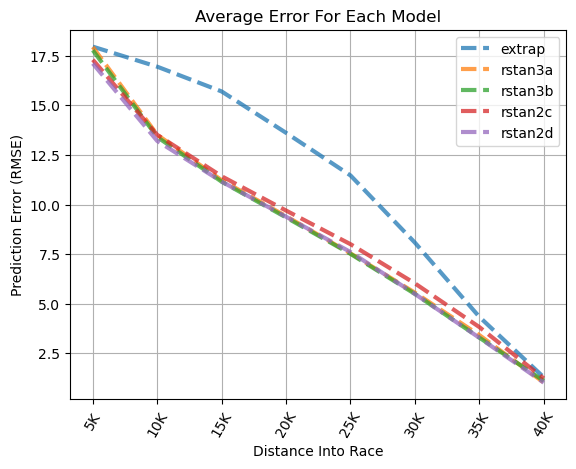

In [22]:
labels = ["extrap", "rstan2a", "rstan2b", "rstan2c", "rstan2d"]
labels = ["extrap", "rstan3a", "rstan3b", "rstan2c", "rstan2d"]

colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]
colors = ["C0", "C1", "C2", "C3", "C4"]
styles = '--'
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
table_group = test2.groupby(["dist"])[labels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
print(table_group)
table_group.plot(label=table_group.columns,  style=styles, linewidth=3, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Prediction Error (RMSE)")
plt.xticks(rotation=60)
plt.title("Average Error For Each Model")
plt.grid(True)
plt.legend()
plt.savefig("analysis/all_errors3.png", bbox_inches="tight")

In [12]:
1 - (table_group["rstan2d"] / table_group["extrap"])

dist
5K     0.041065
10K    0.217202
15K    0.287078
20K    0.308445
25K    0.334291
30K    0.316536
35K    0.238276
40K    0.195118
dtype: float64

In [ ]:
model_preds2 = {}

for k, v in model_info.items():
    print(k, v)
    preds = (42195 / 60) / get_preds(test, pd.read_csv(v[0]), feats_lis=v[1], beta_lis=v[2], propleft=v[3], full=True)
    model_preds2[k] = preds

rstan2a ('stan_results/rs_result2a.csv', ['total_pace'], ['beta[1]'], True)
rstan2b ('stan_results/rs_result2b.csv', ['total_pace', 'curr_pace'], ['beta[1]', 'beta[2]'], True)
rstan2c ('stan_results/rs_result2c.csv', ['total_pace', 'prop'], ['beta[1]', 'beta[2]'], True)
rstan2d ('stan_results/rs_result2d.csv', ['total_pace', 'curr_pace', 'prop'], ['beta[1]', 'beta[2]', 'beta[3]'], True)
rstan3a ('stan_results/rs_result3a.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]'], True)
rstan3b ('stan_results/rs_result3b.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr', 'male'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], True)
rstan3c ('stan_results/rs_result_1.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr', 'male'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], True)


In [ ]:
model_preds2['rstan2a']

array([[145.81506718, 138.67572303, 157.9871396 , ..., 137.66992281,
        138.50738757, 142.87453437],
       [129.9853674 , 150.32703132, 144.49351351, ..., 167.30475208,
        159.43669754, 141.78737076],
       [138.63915413, 159.77796962, 149.39615814, ..., 144.46782884,
        150.52533936, 142.6172133 ],
       ...,
       [359.50822999, 353.26052034, 364.96372413, ..., 362.07486098,
        361.28543842, 360.83632759],
       [364.27551502, 360.60833765, 369.86191501, ..., 364.73816868,
        358.71852639, 359.35323214],
       [375.30125976, 385.01723045, 381.95819333, ..., 387.32295137,
        380.50224442, 377.97528839]])

In [ ]:
def add_intervals_to_test(data_tbl, preds1, preds2, preds3, preds4):#, q1, q2):
    data = data_tbl.copy()
    for conf, lower, upper in [(50, 25, 75), (80, 10, 90), (95, 2.5, 97.5)]:
        test_true = (42195 / 60) / data["finish"]
        b11, b12 = np.percentile(preds1, [lower, upper], axis=1)
        data[f"stan1-lower{conf}"] = b11
        data[f"stan1-upper{conf}"] = b12
        data[f"stan1-size{conf}"] = b12 - b11
        data[f"stan1-in{conf}"] = (test_true < b12) & (test_true > b11)

        b21, b22 = np.percentile(preds2, [lower, upper], axis=1)
        data[f"stan2-lower{conf}"] = b21
        data[f"stan2-upper{conf}"] = b22
        data[f"stan2-size{conf}"] = b22 - b21
        data[f"stan2-in{conf}"] = (test_true < b22) & (test_true > b21)

        b31, b32 = np.percentile(preds3, [lower, upper], axis=1)
        data[f"stan3-lower{conf}"] = b31
        data[f"stan3-upper{conf}"] = b32
        data[f"stan3-size{conf}"] = b32 - b31
        data[f"stan3-in{conf}"] = (test_true < b32) & (test_true > b31)

        b41, b42 = np.percentile(preds4, [lower, upper], axis=1)
        data[f"stan4-lower{conf}"] = b41
        data[f"stan4-upper{conf}"] = b42
        data[f"stan4-size{conf}"] = b42 - b41
        data[f"stan4-in{conf}"] = (test_true < b42) & (test_true > b41)

    return data

In [ ]:
preds1, preds2, preds3, preds4 = model_preds2["rstan2a"], model_preds2["rstan2b"], model_preds2["rstan2c"], model_preds2["rstan2d"]
# preds1, preds2, preds3, preds4 = model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"]
# preds1, preds2, preds3, preds4 = model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"]
table2 = add_intervals_to_test(test2, preds1, preds2, preds3, preds4)
table2

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,...,stan2-size95,stan2-in95,stan3-lower95,stan3-upper95,stan3-size95,stan3-in95,stan4-lower95,stan4-upper95,stan4-size95,stan4-in95
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.881503,...,32.991834,True,129.921458,160.009923,30.088465,True,130.719686,158.281529,27.561843,True
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.881503,...,41.364131,True,142.164334,179.494656,37.330323,True,143.486669,178.072270,34.585601,True
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.881503,...,37.003454,True,136.314934,169.671069,33.356135,True,137.425762,168.588204,31.162443,True
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.881503,...,33.617091,True,130.797058,161.962773,31.165715,True,132.047154,159.629210,27.582056,True
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.881503,...,42.504858,True,144.675555,182.383032,37.707477,True,145.416474,179.367460,33.950986,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.052020,...,13.605874,True,354.545811,365.595208,11.049397,True,356.275024,366.615904,10.340880,True
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.052020,...,13.703424,True,353.728654,364.485686,10.757033,True,353.896704,364.106960,10.210256,True
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.052020,...,13.479365,True,354.787942,366.094348,11.306405,True,355.562818,365.857223,10.294405,True
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.052020,...,13.957636,True,353.294769,364.402359,11.107590,True,358.077728,368.503187,10.425458,True


/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  r

,stan1-in50,stan2-in50,stan3-in50,stan4-in50,stan1-in80,stan2-in80,stan3-in80,stan4-in80,stan1-in95,stan2-in95,stan3-in95,stan4-in95
dist,,,,,,,,,,,,
5K,0.79375,0.77125,0.47875,0.44375,0.94875,0.93750,0.89500,0.84375,0.98750,0.98250,0.99125,0.97625
10K,0.76750,0.73250,0.56375,0.52625,0.93125,0.91625,0.93750,0.90500,0.98250,0.97875,0.99250,0.98625
15K,0.72250,0.68250,0.59000,0.55750,0.91125,0.90125,0.94375,0.92250,0.97875,0.97500,0.98500,0.98125
20K,0.70500,0.65875,0.59500,0.57250,0.90750,0.89000,0.92750,0.91125,0.97500,0.97125,0.98500,0.97750
25K,0.65875,0.62500,0.61500,0.61625,0.89375,0.88125,0.91125,0.90375,0.96500,0.96000,0.97500,0.97250
30K,0.69875,0.69750,0.56875,0.56125,0.90250,0.90625,0.89625,0.89875,0.97125,0.97000,0.97500,0.97250
35K,0.74250,0.82125,0.48250,0.50625,0.93750,0.95625,0.86125,0.91250,0.97625,0.98125,0.97000,0.97750
40K,0.35500,0.60875,0.48875,0.71625,0.75750,0.93500,0.84375,0.91375,0.96625,0.98375,0.96750,0.97875


<Figure size 4000x4000 with 0 Axes>

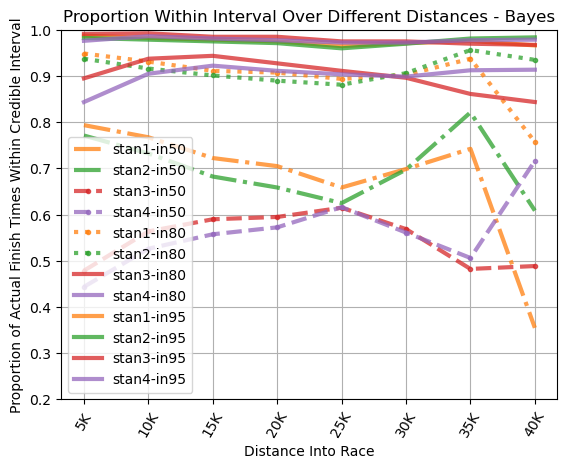

In [ ]:
colors = ['C1', 'C2', 'C3', 'C4'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"stan1-in{conf}", f"stan2-in{conf}", f"stan3-in{conf}", f"stan4-in{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: np.sum(x) / len(x)).loc[mks]
    tables.append(table3)

plt.figure(figsize=(40, 40))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style=["-."] * 2 + ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.75, color=colors)
# plt.ylim(0.2, 1) 
plt.legend(loc="lower center")

plt.xlabel("Distance Into Race")
plt.ylabel("Proportion of Actual Finish Times Within Credible Interval")
plt.xticks(rotation=60)
plt.ylim(0.2, 1)
plt.title("Proportion Within Interval Over Different Distances - Bayes")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/interval_check_bayes.png", bbox_inches="tight")
big_table

<Figure size 3000x2000 with 0 Axes>

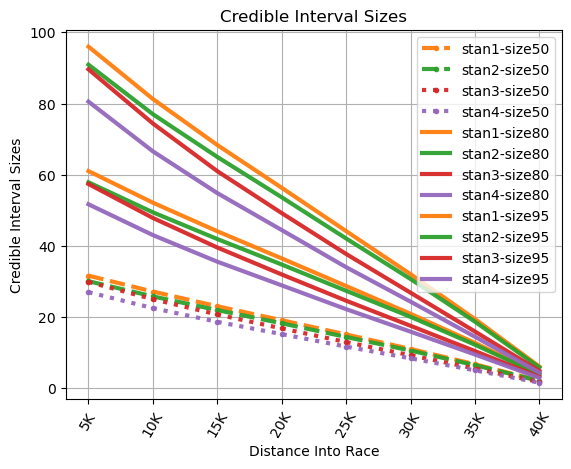

In [ ]:
colors = ['C1', 'C2', 'C3', 'C4'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"stan1-size{conf}", f"stan2-size{conf}", f"stan3-size{conf}", f"stan4-size{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
    tables.append(table3)

plt.figure(figsize=(30, 20))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style= ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.95, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Credible Interval Sizes")
plt.xticks(rotation=60)
plt.title("Credible Interval Sizes")
plt.grid(True)
plt.savefig("analysis/interval_sizes_bayes2.png", bbox_inches="tight")
